In [19]:
from tqdm.notebook import tqdm
import time

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
tf.test.is_gpu_available()

True

In [22]:
total_data = pd.read_csv('./save_data/naver_review_puretext.csv')
total_data = total_data[['score','review']]
total_data[:10]

,score,review
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서 개 더 구매했어요 이가격에 대박입니다 바느질이 조금 엉...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다 전화...
4,5,민트색상 예뻐요 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...
6,1,주문을 월 에 시켰는데 월 일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화도 안되고...
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요
9,2,인데 전문속옷브랜드 위생팬티 보다 작은듯해요 불편해요 밴딩부분이 다 신축성없는 일반...


In [23]:
#긍정과 부정 라벨 붙여주기
#긍정 : score > 3 부정 : score < 3
total_data['label'] = np.select([total_data.score>3],[1],default=0)
total_data[:10]

,score,review,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서 개 더 구매했어요 이가격에 대박입니다 바느질이 조금 엉...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다 전화...,0
4,5,민트색상 예뻐요 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...,0
6,1,주문을 월 에 시켰는데 월 일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화도 안되고...,0
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요,0
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요,0
9,2,인데 전문속옷브랜드 위생팬티 보다 작은듯해요 불편해요 밴딩부분이 다 신축성없는 일반...,0


In [24]:
print('null 유무 : ',total_data.isnull().values.any())
total_data.drop_duplicates(subset=['review'], inplace = True)

print('총 샘플 수 : ',len(total_data))

null 유무 :  False
총 샘플 수 :  199286


훈련용 리뷰의 개수 : 149464
테스트용 리뷰의 개수 : 49822
   label  count
0      0  74739
1      1  74725


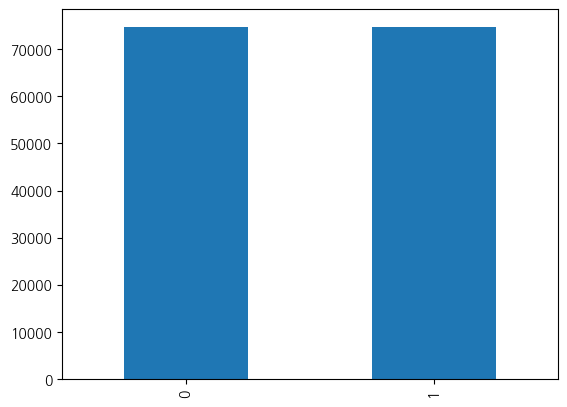

In [25]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)

print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [26]:
mecab = Mecab("C:/mecab/mecab-ko-dic")
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

train_data['tokenized'] = train_data['review'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['review'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


In [27]:
train_data[:5]

,score,review,label,tokenized
186139,2,그냥 그렇내요 생각보다 좀 아쉬운 제품입니다,0,"[그냥, 그렇, 내요, 생각, 보다, 좀, 아쉬운, 제품, 입니다]"
33309,2,고구마 뿌리가 너무 많아요 못생긴건 괜찮은덕 고구마가 전체적으로 뿌리가 너무많고 심...,0,"[고구마, 뿌리, 너무, 많, 아요, 못생긴, 건, 괜찮, 덕, 고구마, 전체, 적..."
110816,1,정말 실망스럽습니다 너무 얇아서 옷을 안걸어도 휘청이네요 옷걸이는 무엇보다 견고한게...,0,"[정말, 실망, 스럽, 습니다, 너무, 얇, 아서, 옷, 안, 걸어도, 휘청이, 네..."
110381,5,기대하지않고 고기류는 처음구매해보았는데 고기가 너무 좋아서 다른 부유도 사고싶네요 ...,1,"[기대, 않, 고기, 류, 처음, 구매, 해, 보, 았, 는데, 고기, 너무, 좋,..."
34333,5,네 잘받았습니다 너무좋아요 판매자님 친절하게 답변 잘해주셔서 고맙습니다,1,"[잘, 받, 았, 습니다, 너무, 좋, 아요, 판매자, 님, 친절, 답변, 잘, 해..."


In [28]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

negative_word_count = Counter(negative_words)
print('negative')
print(negative_word_count.most_common(20))
print()
positive_word_count = Counter(positive_words)
print('positive')
print(positive_word_count.most_common(20))

negative
[('네요', 31972), ('는데', 20280), ('안', 19760), ('어요', 14656), ('너무', 13206), ('있', 13181), ('했', 11750), ('좋', 9729), ('배송', 9579), ('같', 9136), ('거', 8973), ('어', 8870), ('구매', 8813), ('없', 8811), ('아요', 8682), ('되', 8516), ('습니다', 8456), ('그냥', 8320), ('잘', 8061), ('않', 7953)]

positive
[('좋', 39359), ('아요', 21046), ('네요', 19846), ('어요', 18666), ('잘', 18556), ('구매', 16195), ('습니다', 13515), ('있', 12367), ('배송', 12228), ('는데', 11746), ('했', 9798), ('합니다', 9790), ('먹', 9636), ('재', 9282), ('너무', 8364), ('같', 7909), ('만족', 7249), ('거', 6569), ('어', 6354), ('쓰', 6228)]


긍정 리뷰의 평균 길이 : 13.64507193041151
부정 리뷰의 평균 길이 : 17.131872248759013


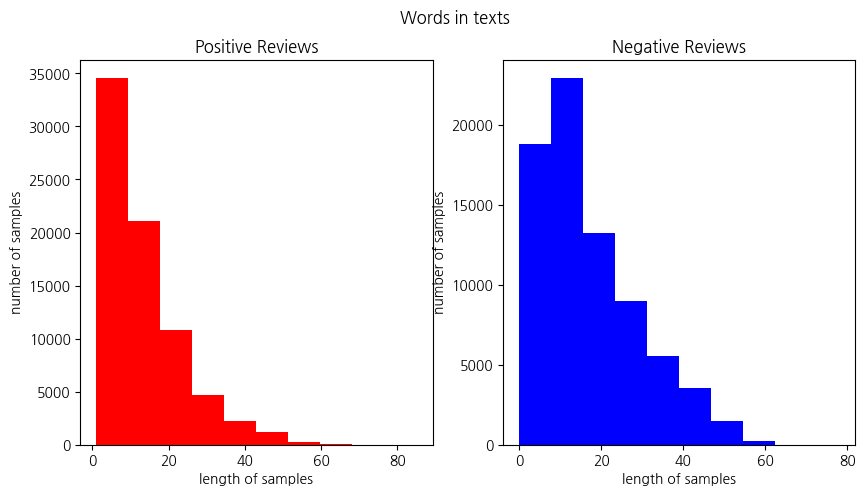

In [29]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [30]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [31]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39382
등장 빈도가 1번 이하인 희귀 단어의 수: 17747
단어 집합에서 희귀 단어의 비율: 45.063734701132496
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7715929283184213


In [32]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21637


In [33]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [34]:
print(X_train[:3])
print(X_test[:3])

[[43, 346, 719, 52, 36, 51, 958, 45, 55], [751, 911, 13, 113, 6, 12509, 143, 85, 1934, 751, 652, 117, 34, 911, 13, 113, 4080, 8, 47, 18, 23, 131, 2, 238, 13, 1541, 29, 124, 10, 18, 4], [92, 185, 250, 11, 13, 172, 42, 268, 10, 4951, 1, 2, 1220, 699, 36, 791, 850, 103, 295, 51, 403, 2]]
[[3, 11, 73, 252, 79, 8, 5633, 45, 57, 7, 615, 22], [13, 327, 808, 3560, 16308, 5798, 31, 35, 305, 7283, 326, 5, 58, 4406, 162, 1353, 4, 253, 143, 443, 438], [59, 2964, 54, 243, 127, 78, 244, 94, 283, 1422, 141, 1, 5, 448, 1743, 10, 346, 283, 1, 125, 1445, 515, 3521, 4657, 2076, 179, 584, 14, 5, 3120, 78, 610, 448, 1988, 156, 1832, 171, 448, 215, 2328, 799, 78]]


리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.388635390461918


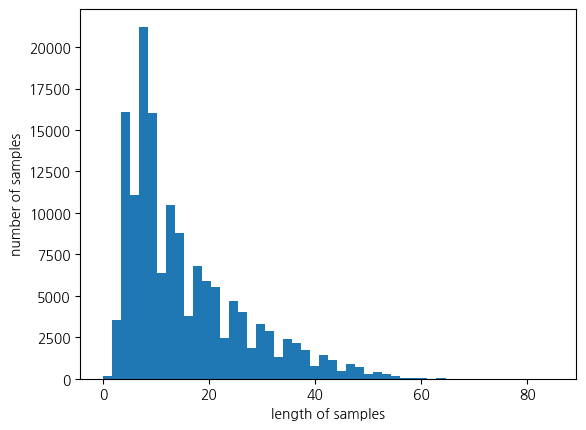

In [35]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [36]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))
max_len = 80

below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99866188513622


In [37]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [41]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1868/1869 [============================>.] - ETA: 0s - loss: 0.2637 - acc: 0.8997
Epoch 1: val_acc improved from -inf to 0.91633, saving model to best_model.h5
1869/1869 [==============================] - 30s 13ms/step - loss: 0.2637 - acc: 0.8997 - val_loss: 0.2278 - val_acc: 0.9163
Epoch 2/15
1865/1869 [============================>.] - ETA: 0s - loss: 0.1910 - acc: 0.9323
Epoch 2: val_acc improved from 0.91633 to 0.91684, saving model to best_model.h5
1869/1869 [==============================] - 23s 12ms/step - loss: 0.1910 - acc: 0.9323 - val_loss: 0.2237 - val_acc: 0.9168
Epoch 3/15
1869/1869 [==============================] - ETA: 0s - loss: 0.1579 - acc: 0.9445
Epoch 3: val_acc improved from 0.91684 to 0.91754, saving model to best_model.h5
1869/1869 [==============================] - 23s 12ms/step - loss: 0.1579 - acc: 0.9445 - val_loss: 0.2310 - val_acc: 0.9175
Epoch 4/15
1866/1869 [============================>.] - ETA: 0s - loss: 0.1331 - acc: 0.9532
Epoch 4: val_

In [52]:
#load_model = tf.keras.models.load_model('./model/GRU_Model.h5')
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(model.predict(pad_new))
  print("score : ", score)
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))


In [69]:
sentiment_predict('택배포장 테이프도 비닐이 아니라 종이 테이프면 더 좋을 것 같아요.')

1/1 [==============================] - 0s 21ms/step
score :  0.2444353848695755
75.56% 확률로 부정 리뷰입니다.


In [45]:
model.save('./model/GRU_Model.h5')
#load_model = tf.keras.models.load_model('./model/GRU_Model.h5')